In [1]:
# Local imports
import os
import sys
import glob
import re

# Third party imports
import numpy as np
import xarray as xr
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

In [2]:
# Import dicionaries
sys.path.append('/home/users/benhutch/skill-maps')
import dictionaries as dic

# Import functions
import functions as func

# Import the NAO functions
from nao_skill_functions import nao_stats, \
                                plot_subplots_ind_models, plot_multi_model_mean, \
                                plot_multi_model_mean_spna, \
                                plot_subplots_ind_models_spna

# Import nao matching functions
sys.path.append('/home/users/benhutch/skill-maps/rose-suite-matching')
from nao_matching_seasons import match_variable_models, find_obs_path

# Import the bootstrapping functions
from process_bs_values import align_nao_matched_members, load_and_process_hist_data, \
                                extract_hist_models

### NAO/SPNA Matching ###

Testing whether:
1. Does NAO matching improve skill for the SPNA SSTs (tas in this case).
2. Does SPNA matching improve skill for the NAO anomalies

In the first case, we will consider whether NAO-matching improves the skill for SPNA SSTs. We want to create two subplots, one on the left showing the raw SPNA SST time series and the other (on the right) showing the NAO-matched SPNA SST time series. If NAO-matching improves the skill of the SPNA SST time series, this suggests that NAO may be a driver of predicability for the SPNA SSTs.

$\hat{F}_{SPNA} = \hat{F}_{NAO} + \hat{F}_{OTHER} + \hat{\epsilon}$

In the second case, we will consider whether SPNA SST matching improves the skill for NAO anomalies. By doing this we assume that some of the predicability for the NAO derives from SPNA SSTs, e.g.

$\hat{F}_{NAO} = \hat{F}_{SPNA} + \hat{F}_{OTHER} + \hat{\epsilon}$

In [3]:
# Set up the parameters
variable = "tas"
region = "global"
forecast_range = "2-9"
season = "DJFM"
start_year = 1960
end_year = 2022

# set up the base canari dir
canari_dir = "/gws/nopw/j04/canari/users/benhutch"

# Form the folder within which the data are stored
data_dir = os.path.join(canari_dir, "NAO-matching",
                        variable, region, season,
                        forecast_range, str(start_year) + "-" + str(end_year))

# Check if the data directory exists
if not os.path.exists(data_dir):
    raise ValueError("Data directory does not exist")

# Print the files stored in the data directory
print("Files in data directory:")
files = os.listdir(data_dir)

# Print the files
for file in files:
    print(file)

# Extract the file containing "members_lagged"
members_lagged_file = [file for file in files if "members_lagged" in file][0]

# Open the file
nao_matched_tas_members = xr.open_dataset(os.path.join(data_dir,
                                                        members_lagged_file))

Files in data directory:
tas_global_DJFM_2-9_1960-2022_matched_var_ensemble_mean.nc
tas_global_DJFM_2-9_1960-2022_matched_var_ensemble_mean_lagged.nc
tas_global_DJFM_2-9_1960-2022_matched_var_ensemble_members.nc
tas_global_DJFM_2-9_1960-2022_matched_var_ensemble_members_lagged.nc


In [4]:
# variable contained here is:
# '__xarray_dataarray_variable__'
nao_matched_tas_members

<xarray.Dataset>
Dimensions:                        (time: 50, member: 20, lat: 72, lon: 144)
Coordinates:
  * time                           (time) int64 1969 1970 1971 ... 2017 2018
  * member                         (member) int64 0 1 2 3 4 5 ... 15 16 17 18 19
  * lat                            (lat) float64 -90.0 -87.5 -85.0 ... 85.0 87.5
  * lon                            (lon) float64 -180.0 -177.5 ... 175.0 177.5
Data variables:
    __xarray_dataarray_variable__  (time, member, lat, lon) float64 ...

In [5]:
# Extract the observations
obs_tas_anom = func.read_obs(variable=variable,
                             region=region,
                             forecast_range=forecast_range,
                             season=season,
                             observations_path=dic.obs,
                             start_year=start_year,
                             end_year=end_year)

Time dimension of obs: ['1960-12-31T00:00:00.000000000' '1961-12-31T00:00:00.000000000'
 '1962-12-31T00:00:00.000000000' '1963-12-31T00:00:00.000000000'
 '1964-12-31T00:00:00.000000000' '1965-12-31T00:00:00.000000000'
 '1966-12-31T00:00:00.000000000' '1967-12-31T00:00:00.000000000'
 '1968-12-31T00:00:00.000000000' '1969-12-31T00:00:00.000000000'
 '1970-12-31T00:00:00.000000000' '1971-12-31T00:00:00.000000000'
 '1972-12-31T00:00:00.000000000' '1973-12-31T00:00:00.000000000'
 '1974-12-31T00:00:00.000000000' '1975-12-31T00:00:00.000000000'
 '1976-12-31T00:00:00.000000000' '1977-12-31T00:00:00.000000000'
 '1978-12-31T00:00:00.000000000' '1979-12-31T00:00:00.000000000'
 '1980-12-31T00:00:00.000000000' '1981-12-31T00:00:00.000000000'
 '1982-12-31T00:00:00.000000000' '1983-12-31T00:00:00.000000000'
 '1984-12-31T00:00:00.000000000' '1985-12-31T00:00:00.000000000'
 '1986-12-31T00:00:00.000000000' '1987-12-31T00:00:00.000000000'
 '1988-12-31T00:00:00.000000000' '1989-12-31T00:00:00.000000000'
 '

/apps/jasmin/jaspy/miniconda_envs/jaspy3.10/m3-4.9.2/envs/jaspy3.10-m3-4.9.2-r20220721/lib/python3.10/site-packages/iris/coords.py:2220: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))


In [6]:
# Load and process historical data first (for the align function)
hist_data = load_and_process_hist_data(base_dir="/home/users/benhutch/skill-maps-processed-data/historical",
                                       hist_models=extract_hist_models(variable, dic),
                                       variable=variable,
                                       region=region,
                                       forecast_range=forecast_range,
                                       season=season)

# Constrain the historical data to the same time period as the observations
constrained_hist_data = func.constrain_years(hist_data,
                                             extract_hist_models(variable, dic))

processing model:  BCC-CSM2-MR
files_path:  /home/users/benhutch/skill-maps-processed-data/historical/tas/BCC-CSM2-MR/global/years_2-9/DJFM/outputs/processed/*.nc
processing model:  MPI-ESM1-2-HR
files_path:  /home/users/benhutch/skill-maps-processed-data/historical/tas/MPI-ESM1-2-HR/global/years_2-9/DJFM/outputs/processed/*.nc
processing model:  CanESM5
files_path:  /home/users/benhutch/skill-maps-processed-data/historical/tas/CanESM5/global/years_2-9/DJFM/outputs/processed/*.nc
processing model:  CMCC-CM2-SR5
files_path:  /home/users/benhutch/skill-maps-processed-data/historical/tas/CMCC-CM2-SR5/global/years_2-9/DJFM/outputs/processed/*.nc
processing model:  HadGEM3-GC31-MM
files_path:  /home/users/benhutch/skill-maps-processed-data/historical/tas/HadGEM3-GC31-MM/global/years_2-9/DJFM/outputs/processed/*.nc
processing model:  MPI-ESM1-2-LR
files_path:  /home/users/benhutch/skill-maps-processed-data/historical/tas/MPI-ESM1-2-LR/global/years_2-9/DJFM/outputs/processed/*.nc
processing m

In [7]:
# Align the members using the function
aligned_data = align_nao_matched_members(obs=obs_tas_anom,
                                         nao_matched_members=nao_matched_tas_members,
                                         constrained_hist_data=constrained_hist_data,
                                         hist_models=extract_hist_models(variable, dic))

there are NaN values in the observations for 1960
all values are NaN for 1960
there are NaN values in the observations for 1961
all values are NaN for 1961
there are NaN values in the observations for 1962
all values are NaN for 1962
there are NaN values in the observations for 1963
all values are NaN for 1963
there are no NaN values in the observations for 1964
there are no NaN values in the observations for 1965
there are no NaN values in the observations for 1966
there are no NaN values in the observations for 1967
there are no NaN values in the observations for 1968
there are no NaN values in the observations for 1969
there are no NaN values in the observations for 1970
there are no NaN values in the observations for 1971
there are no NaN values in the observations for 1972
there are no NaN values in the observations for 1973
there are no NaN values in the observations for 1974
there are no NaN values in the observations for 1975
there are no NaN values in the observations for 1976

In [8]:
# Import importlib
import importlib

# Reload the dicionaries
importlib.reload(sys.modules['dictionaries'])

# Reload the functions
importlib.reload(sys.modules['functions'])

# Reload the nao functions
importlib.reload(sys.modules['nao_skill_functions'])

# Reload the nao matching functions
importlib.reload(sys.modules['nao_matching_seasons'])

# Reload the bootstrapping functions
importlib.reload(sys.modules['process_bs_values'])

# Import the dicionaries
import dictionaries as dic

# Import the functions
import functions as func

# Import the nao functions
from nao_skill_functions import nao_stats, \
                                plot_subplots_ind_models, plot_multi_model_mean, \
                                plot_multi_model_mean_spna, \
                                plot_subplots_ind_models_spna

# Import nao matching functions
sys.path.append('/home/users/benhutch/skill-maps/rose-suite-matching')
from nao_matching_seasons import match_variable_models, find_obs_path

# Import the bootstrapping functions
from process_bs_values import align_nao_matched_members, load_and_process_hist_data, \
                                extract_hist_models

In [9]:
# extract the data from the aligned data
nao_matched_tas_members_array = aligned_data[0]
obs_tas_anom = aligned_data[2]
common_years = aligned_data[3]

# Print the shape of the data
print(nao_matched_tas_members_array.shape)
print(obs_tas_anom.shape)
print(common_years.shape)
print(common_years)

(20, 43, 72, 144)
(43, 72, 144)
(43,)
[1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982
 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996
 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010
 2011]


In [10]:
# We want to find the indexes for lat and lon
# which correspond to the SPNA region for the regridded data
lats = nao_matched_tas_members.lat.values
lons = nao_matched_tas_members.lon.values

# Print the lats and lons
print(lats)
print(lons)

# Extract the lats and lons for the SPNA region
lat1, lat2 = dic.spna_grid_smith['lat1'], dic.spna_grid_smith['lat2']
lon1, lon2 = dic.spna_grid_smith['lon1'], dic.spna_grid_smith['lon2']

# Print the lats and lons
print(lat1, lat2)
print(lon1, lon2)

# Find the indexes for the lat and lon
# Find the values closest to the lat and lon
lat1_idx = np.argmin(np.abs(lats - lat1))
lat2_idx = np.argmin(np.abs(lats - lat2))
lon1_idx = np.argmin(np.abs(lons - lon1))
lon2_idx = np.argmin(np.abs(lons - lon2))

# Print the indexes
print(lat1_idx, lat2_idx, lon1_idx, lon2_idx)

# Constrain the lats and lons to the SPNA region
lats_spna = lats[lat1_idx:lat2_idx + 1]
lons_spna = lons[lon1_idx:lon2_idx + 1]

# Print the lats and lons
print(lats_spna)
print(lons_spna)

[-90.  -87.5 -85.  -82.5 -80.  -77.5 -75.  -72.5 -70.  -67.5 -65.  -62.5
 -60.  -57.5 -55.  -52.5 -50.  -47.5 -45.  -42.5 -40.  -37.5 -35.  -32.5
 -30.  -27.5 -25.  -22.5 -20.  -17.5 -15.  -12.5 -10.   -7.5  -5.   -2.5
   0.    2.5   5.    7.5  10.   12.5  15.   17.5  20.   22.5  25.   27.5
  30.   32.5  35.   37.5  40.   42.5  45.   47.5  50.   52.5  55.   57.5
  60.   62.5  65.   67.5  70.   72.5  75.   77.5  80.   82.5  85.   87.5]
[-180.  -177.5 -175.  -172.5 -170.  -167.5 -165.  -162.5 -160.  -157.5
 -155.  -152.5 -150.  -147.5 -145.  -142.5 -140.  -137.5 -135.  -132.5
 -130.  -127.5 -125.  -122.5 -120.  -117.5 -115.  -112.5 -110.  -107.5
 -105.  -102.5 -100.   -97.5  -95.   -92.5  -90.   -87.5  -85.   -82.5
  -80.   -77.5  -75.   -72.5  -70.   -67.5  -65.   -62.5  -60.   -57.5
  -55.   -52.5  -50.   -47.5  -45.   -42.5  -40.   -37.5  -35.   -32.5
  -30.   -27.5  -25.   -22.5  -20.   -17.5  -15.   -12.5  -10.    -7.5
   -5.    -2.5    0.     2.5    5.     7.5   10.    12.5   15.  

In [11]:
# Collapse the nao_matched and obs data to the SPNA region
# Constrain to the region
# and take the mean over the lat and lon axes
nao_matched_tas_members_spna = nao_matched_tas_members_array[:, :,
                                                            lat1_idx:lat2_idx + 1,
                                                            lon1_idx:lon2_idx + 1].mean(axis=(2, 3))

# Print the shape of the data
print(nao_matched_tas_members_spna.shape)

# Collapse the obs data to the SPNA region
# Constrain to the region
# and take the mean over the lat and lon axes
obs_tas_anom_spna = obs_tas_anom[:, lat1_idx:lat2_idx + 1,
                                 lon1_idx:lon2_idx + 1].mean(axis=(1, 2))

# Print the shape of the data
print(obs_tas_anom_spna.shape)

(20, 43)
(43,)


In [12]:
# Also import the raw data for comparison
raw_dir = "/gws/nopw/j04/canari/users/benhutch/bootstrapping/tas/global/DJFM/2-9/raw/no_bootstraps_1"

# find the files containing "ts" in this directory
files = os.listdir(raw_dir)

# # Print the files
# for file in files:
#     print(file)

# Extract the file containing "ts"
ts_file = [file for file in files if "fcst1_ts" in file][0]

# Extract the file containing "obs_ts"
obs_ts_file = [file for file in files if "obs_ts" in file][0]

# Extract the years from the file name
years_file = [file for file in files if "years" in file][0]

# find the file containing nens1_tas
nens1_tas_file = [file for file in files if "nens1_tas" in file][0]

# Open the file
print(ts_file)

# Open the file
print(obs_ts_file)

# print what is contained within the nens1_tas .txt file
with open(os.path.join(raw_dir, nens1_tas_file), 'r') as f:
    print(f.read())

# Print what is contained within the years .txt file
# with open(os.path.join(raw_dir, years_file), 'r') as f:
#     print(f.read())
# 1966 to 2011
# generate an array of years
years = np.arange(1966, 2012)

# print the length of the years
print(len(years))

# How can I select the inidcies from 1969 to 2011?
# I can use np.where
# Find the indices for the years
start_year_nm = 1969
end_year_nm = 2011

# Find the indices for the years
start_idx = np.where(years == start_year_nm)[0][0]
end_idx = np.where(years == end_year_nm)[0][0]

# Print the indices
print(start_idx, end_idx)
print(years[start_idx], years[end_idx])

# Open these .npy files
fcst1_ts = np.load(os.path.join(raw_dir, ts_file))
obs_ts = np.load(os.path.join(raw_dir, obs_ts_file))

# Print the shape of the data
print(fcst1_ts.shape)
print(obs_ts.shape)

# Extract the data for the SPNA region
fcst1_ts_spna = fcst1_ts[start_idx:, lat1_idx:lat2_idx + 1,
                         lon1_idx:lon2_idx + 1].mean(axis=(1, 2))

# extract the obs data for the SPNA region
obs_ts_spna = obs_ts[start_idx:, lat1_idx:lat2_idx + 1,
                     lon1_idx:lon2_idx + 1].mean(axis=(1, 2))

# Print the shape of the data
print(fcst1_ts_spna.shape)
print(obs_ts_spna.shape)

fcst1_ts_tas_global_DJFM_2-9.npy
obs_ts_tas_global_DJFM_2-9.npy
1.600000000000000000e+02

46
3 45
1969 2011
(46, 72, 144)
(46, 72, 144)
(43,)
(43,)


### NAO-matched SPNA time series ###

* Subplot with raw on the left and nao-matched on the right

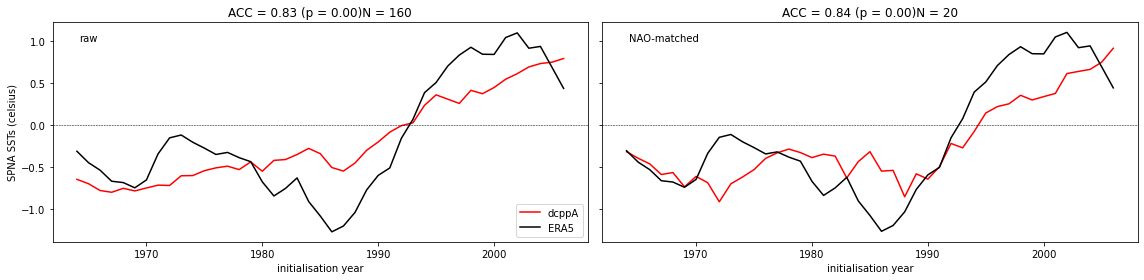

In [13]:
# Set up the figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(16, 4), sharex=True, sharey=True)

# Set up the no. ensemble members
nao_match_nens = 20
raw_nens = 160 # approx - some may be missing

# take the mean over the 0th axis for the nao matched data
nao_match_mean = nao_matched_tas_members_spna.mean(axis=0)

# Calculate the correlation coefficient for the raw
corr_raw, p_raw = pearsonr(fcst1_ts_spna, obs_ts_spna)

# Calculate the correlation coefficient for the nao matched
corr_nm, p_nm = pearsonr(nao_match_mean, obs_tas_anom_spna)

# Can't calculate RPC as don't have all members for the raw data

# Set up the axes
ax1 = ax[0] ; ax2 = ax[1]

# Plot the ensemble mean for the raw data
ax1.plot(years[start_idx:] - 5, fcst1_ts_spna, color='red', label='dcppA')

# Plot the observed data
ax1.plot(years[start_idx:] - 5, obs_ts_spna, color='black', label='ERA5')

# Set up the titles
ax1.set_title(f"ACC = {corr_raw:.2f} (p = {p_raw:.2f})"
              f"N = {raw_nens}")

# Format a textbox containing raw in the top left corner
ax1.text(0.05, 0.95, 'raw', transform=ax1.transAxes,
         ha="left", va="top",
            fontsize=10)

# Plot the ensemble mean for the nao matched data
ax2.plot(years[start_idx:] - 5, nao_match_mean, color='red', label='dcppA')

# Plot the observed data
ax2.plot(years[start_idx:] - 5, obs_tas_anom_spna, color='black', label='ERA5')

# Set up the titles
ax2.set_title(f"ACC = {corr_nm:.2f} (p = {p_nm:.2f})"
              f"N = {nao_match_nens}")

# Format a textbox containing nao matched in the top left corner
ax2.text(0.05, 0.95, 'NAO-matched', transform=ax2.transAxes,
            ha="left", va="top",
                fontsize=10)

# Set up the legend
ax1.legend(loc='lower right', fontsize=10)

# Set up zero lines
ax1.axhline(0, color='black', linestyle='--', linewidth=0.5)
ax2.axhline(0, color='black', linestyle='--', linewidth=0.5)

# Set the y-axis label for the left column
ax1.set_ylabel("SPNA SSTs (celsius)")

# Set a common x-axis label
ax1.set_xlabel("initialisation year")
ax2.set_xlabel("initialisation year")

# Specify the tight layout
plt.tight_layout()

# Show the plot
plt.show()

### SPNA matched NAO ###

* First process NAO-matched data for longer time period (up to s2014 rather than s2006)
* To get long and short comparison for NAO-matched skill

* Then modify *nao_matching_seasons.py* for SPNA matching (based on tas fields) for NAO (psl fields).

In [3]:
# Import importlib to reload the functions
import importlib

# Reload the dictionaries
importlib.reload(sys.modules['dictionaries'])

# Reload the functions
importlib.reload(sys.modules['functions'])

# Reload the nao_skill_functions
importlib.reload(sys.modules['nao_skill_functions'])

# Reload the nao_matching_seasons
importlib.reload(sys.modules['nao_matching_seasons'])

# Reload the process_bs_values
importlib.reload(sys.modules['process_bs_values'])

# Import the dictionaries
import dictionaries as dic

# Import the functions
import functions as func

# Import the nao functions
from nao_skill_functions import nao_stats, \
                                plot_subplots_ind_models, plot_multi_model_mean, \
                                plot_multi_model_mean_spna, \
                                plot_subplots_ind_models_spna

# Import nao matching functions
from nao_matching_seasons import match_variable_models, find_obs_path

# Import the bootstrap functions
from process_bs_values import align_nao_matched_members, load_and_process_hist_data, \
                                extract_hist_models

In [4]:
# Define the parameters for SPNA matching for NAO
match_var = "psl" # matching the psl fields to then calculate the NAO index
region = "global"
season = "DJFM"
forecast_range = "2-9"
start_year = 1960
end_year = 2022
lag = 0 # No lag needed for SPNA SSTs - RPC ~ 1
no_subset_members = 20 # No. members to average over
level = 100000 # 1000 hPa in Pa

# Other parameters
base_dir = dic.base_dir

In [5]:
# Process the tas observations for the SPNA index
obs_tas_anomaly = func.read_obs(
    variable="tas",
    region=region,
    forecast_range=forecast_range,
    season=season,
    observations_path=dic.obs,
    start_year=start_year,
    end_year=end_year,
)

/opt/jaspy/lib/python3.10/site-packages/iris/coords.py:2249: UserWarning: Cannot check if coordinate is contiguous: Invalid operation for 'time', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'time'. Ignoring bounds.
  warnings.warn(msg.format(str(exc), self.name()))


Time dimension of obs: ['1960-12-31T00:00:00.000000000' '1961-12-31T00:00:00.000000000'
 '1962-12-31T00:00:00.000000000' '1963-12-31T00:00:00.000000000'
 '1964-12-31T00:00:00.000000000' '1965-12-31T00:00:00.000000000'
 '1966-12-31T00:00:00.000000000' '1967-12-31T00:00:00.000000000'
 '1968-12-31T00:00:00.000000000' '1969-12-31T00:00:00.000000000'
 '1970-12-31T00:00:00.000000000' '1971-12-31T00:00:00.000000000'
 '1972-12-31T00:00:00.000000000' '1973-12-31T00:00:00.000000000'
 '1974-12-31T00:00:00.000000000' '1975-12-31T00:00:00.000000000'
 '1976-12-31T00:00:00.000000000' '1977-12-31T00:00:00.000000000'
 '1978-12-31T00:00:00.000000000' '1979-12-31T00:00:00.000000000'
 '1980-12-31T00:00:00.000000000' '1981-12-31T00:00:00.000000000'
 '1982-12-31T00:00:00.000000000' '1983-12-31T00:00:00.000000000'
 '1984-12-31T00:00:00.000000000' '1985-12-31T00:00:00.000000000'
 '1986-12-31T00:00:00.000000000' '1987-12-31T00:00:00.000000000'
 '1988-12-31T00:00:00.000000000' '1989-12-31T00:00:00.000000000'
 '

In [8]:
# Load and process the model data for the SPNA index
model_datasets_tas = func.load_data(
    base_directory=base_dir,
    models=dic.tas_models,
    variable="tas",
    region=region,
    forecast_range=forecast_range,
    season=season, # model season only needed for MAM, JJA (MAY, ULG)
)

# Process the model data - extract the tas variable
model_data_tas, _ = func.process_data(
    datasets_by_model=model_datasets_tas,
    variable="tas"
)

# Constrain the years to make sure all the models have the same time period
# e.g. that of BCC-CSM2-MR
model_data_tas = func.constrain_years(
    model_data=model_data_tas,
    models=dic.tas_models
)

Non-consecutive years found in /home/users/benhutch/skill-maps-processed-data/tas/FGOALS-f3-L/global/years_2-9/DJFM/outputs/mergetime/mergetime_FGOALS-f3-L_tas_global_2-9_DJFM-r3i1.nc: [1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978
 1979 1980 1981 1982 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993
 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007
 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019]
Non-consecutive years found in /home/users/benhutch/skill-maps-processed-data/tas/FGOALS-f3-L/global/years_2-9/DJFM/outputs/mergetime/mergetime_FGOALS-f3-L_tas_global_2-9_DJFM-r3i1.nc: [1981]-[1982]-[1984]
Member: /home/users/benhutch/skill-maps-processed-data/tas/FGOALS-f3-L/global/years_2-9/DJFM/outputs/mergetime/mergetime_FGOALS-f3-L_tas_global_2-9_DJFM-r3i1.nc has non-consecutive years
Will not be included in the analysis
Counter: 1
Non-consecutive years found in /home/users/benhutch/skill-maps-processed-data/tas/FGOALS-f3-L/globa

In [9]:
# Remove years containing NaNs from the obs and model data
obs_tas_anomaly, model_data_tas, _ = func.remove_years_with_nans_nao(
    observed_data=obs_tas_anomaly,
    model_data=model_data_tas,
    models=dic.tas_models,
    NAO_matched=False,
)

No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN v

Calculating SPNA index for model: BCC-CSM2-MR
Calculating SPNA index for model: MPI-ESM1-2-HR
Calculating SPNA index for model: CanESM5
Calculating SPNA index for model: CMCC-CM2-SR5
Calculating SPNA index for model: HadGEM3-GC31-MM
Calculating SPNA index for model: EC-Earth3
Calculating SPNA index for model: FGOALS-f3-L
Calculating SPNA index for model: MIROC6
Calculating SPNA index for model: IPSL-CM6A-LR
Calculating SPNA index for model: CESM1-1-CAM5-CMIP5
Calculating SPNA index for model: NorCPM1
Plotting SPNA index
dimensions of the lagged: None ensemble:  ('time',)
coordinates of the lagged:  None ensemble:  Coordinates:
  * time     (time) object 1966-08-01 00:00:00 ... 2018-08-01 00:00:00
    height   float64 ...


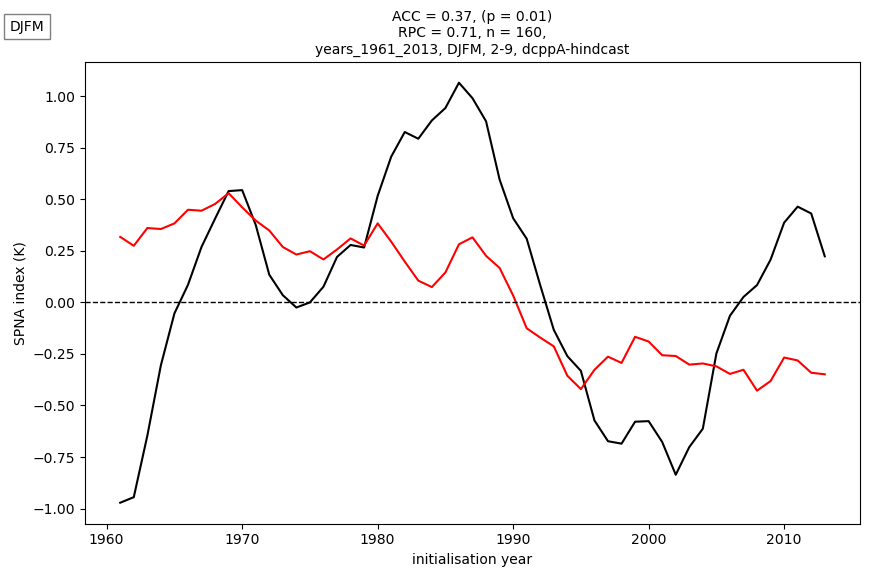

In [10]:
# Calculate the spna index and plot
obs_spna, model_spna = func.calculate_spna_index_and_plot(
    obs_anom=obs_tas_anomaly,
    model_anom=model_data_tas,
    models=dic.tas_models,
    variable="tas",
    season=season,
    forecast_range=forecast_range,
    output_dir=dic.canari_plots_dir,
    plot_graphics=True,
)

In [11]:
# Calculate the ensemble mean model SPNA index
# Initialize an empty array to store the data
model_spna_members = []

# Initialize a counter
counter = 0

# Loop over the models
for model in match_variable_models("tas"):
    # Extract the data for the given model
    model_spna_data = model_spna[model]

    # Loop over the ensemble members
    for member in model_spna_data:

        # If the type of the time is not a datetime64
        if not isinstance(member.time.values[0], np.datetime64):
            # Extract the time values as a datetime64
            member_time = member.time.astype("datetime64[ns]")

            # Add the time values to the member
            member = member.assign_coords(time=member_time)

        # If the counter is 0
        if counter == 0:
            # Extract the coordinates
            coords = member.coords

            # Extract the dimensions
            dims = member.dims

            # Extract the years
            years1 = member.time.dt.year.values

        # Extract the years
        years2 = member.time.dt.year.values

        # Assert that the years are the same
        assert np.all(years1 == years2), "The years are not the same."

        # Append the data to the list
        model_spna_members.append(member)

        # Increment the counter
        counter += 1

# Convert the list to a numpy array
model_spna_members_array = np.array(model_spna_members)

# Print the years for debugging
print("years1:", years1)

# NOTE: Not going to lag the SPNA index for now - RPC ~1
# Don't have to go through the same process of variance adjust
# and lagging
# We are going to assume that this is our 'best guess' for the SPNA index
model_spna_mean = np.mean(model_spna_members_array, axis=0)

match_var: tas
years1: [1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979
 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993
 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007
 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018]


### Matching psl ###

* Now we process psl anomalies for observations and model before going on to sub-select the model and ensemble members which have the 'correct' magnitude of the SPNA index.

In [15]:
# Print which variable we are performing the matching for
print("Performing the SPNA matching for:", match_var)

# Process the matching variable observations
obs_psl_anoms = func.read_obs(
    variable=match_var,
    region=region,
    forecast_range=forecast_range,
    season=season,
    observations_path=dic.obs,
    start_year=start_year,
    end_year=end_year,
)

Performing the SPNA matching for: psl
Time dimension of obs: ['1960-12-31T00:00:00.000000000' '1961-12-31T00:00:00.000000000'
 '1962-12-31T00:00:00.000000000' '1963-12-31T00:00:00.000000000'
 '1964-12-31T00:00:00.000000000' '1965-12-31T00:00:00.000000000'
 '1966-12-31T00:00:00.000000000' '1967-12-31T00:00:00.000000000'
 '1968-12-31T00:00:00.000000000' '1969-12-31T00:00:00.000000000'
 '1970-12-31T00:00:00.000000000' '1971-12-31T00:00:00.000000000'
 '1972-12-31T00:00:00.000000000' '1973-12-31T00:00:00.000000000'
 '1974-12-31T00:00:00.000000000' '1975-12-31T00:00:00.000000000'
 '1976-12-31T00:00:00.000000000' '1977-12-31T00:00:00.000000000'
 '1978-12-31T00:00:00.000000000' '1979-12-31T00:00:00.000000000'
 '1980-12-31T00:00:00.000000000' '1981-12-31T00:00:00.000000000'
 '1982-12-31T00:00:00.000000000' '1983-12-31T00:00:00.000000000'
 '1984-12-31T00:00:00.000000000' '1985-12-31T00:00:00.000000000'
 '1986-12-31T00:00:00.000000000' '1987-12-31T00:00:00.000000000'
 '1988-12-31T00:00:00.0000000

/opt/jaspy/lib/python3.10/site-packages/iris/coords.py:2249: UserWarning: Cannot check if coordinate is contiguous: Invalid operation for 'time', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'time'. Ignoring bounds.
  warnings.warn(msg.format(str(exc), self.name()))


In [18]:
# Load the model data for the matching variable
model_datasets_psl = func.load_data(
    base_directory=base_dir,
    models=dic.models,
    variable=match_var,
    region=region,
    forecast_range=forecast_range,
    season="DJFM",
)

# Process the model data for the matching variable
model_data_psl, _ = func.process_data(
    datasets_by_model=model_datasets_psl, variable=match_var
)

# Make sure that the models have the same time period for the matching variable
model_data_psl = func.constrain_years(
    model_data=model_data_psl, models=dic.models
)

In [23]:
# Remove years containing NaNs from the observations and model data
obs_psl_anoms, model_data_psl, _ = func.remove_years_with_nans_nao(
    observed_data=obs_psl_anoms,
    model_data=model_data_psl,
    models=dic.models,
    NAO_matched=False,
)

No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN v

In [24]:
# Make sure that tas and the matching variable have the same models
# and ensemble members
# before we perform the matching
(
    model_spna_constrained,
    model_data_psl_constrained,
    years_in_both,
) = func.constrain_models_members(
    model_nao=model_spna,
    psl_models=dic.tas_models,
    match_var_model_anomalies=model_data_psl,
    match_var_models=dic.models,
)

# Set up the dimensions for the empty array
# Extract the lats and lons
lats = model_data_psl_constrained["BCC-CSM2-MR"][0].lat.values
lons = model_data_psl_constrained["BCC-CSM2-MR"][0].lon.values

# Set up the empty array
model_spna_constrained_array = np.empty(
    [len(years_in_both), no_subset_members, len(lats), len(lons)]
)

The two models lists are not equal
Constraining the models
Model: BCC-CSM2-MR
Variant labels for the model psl: ['r1i1p1f1', 'r2i1p1f1', 'r4i1p1f1', 'r6i1p1f1', 'r5i1p1f1', 'r3i1p1f1', 'r7i1p1f1', 'r8i1p1f1']
Variant labels for the model match_var: ['r3i1p1f1', 'r7i1p1f1', 'r6i1p1f1', 'r4i1p1f1', 'r2i1p1f1', 'r8i1p1f1', 'r5i1p1f1', 'r1i1p1f1']
The two variant labels lists are equal
Model: CESM1-1-CAM5-CMIP5
Variant labels for the model psl: ['r5i1p1f1', 'r3i1p1f1', 'r7i1p1f1', 'r6i1p1f1', 'r4i1p1f1', 'r10i1p1f1', 'r13i1p1f1', 'r12i1p1f1', 'r14i1p1f1', 'r9i1p1f1', 'r8i1p1f1', 'r11i1p1f1', 'r2i1p1f1', 'r1i1p1f1', 'r25i1p1f1', 'r27i1p1f1', 'r26i1p1f1', 'r22i1p1f1', 'r24i1p1f1', 'r28i1p1f1', 'r31i1p1f1', 'r19i1p1f1', 'r21i1p1f1', 'r20i1p1f1', 'r17i1p1f1', 'r16i1p1f1', 'r18i1p1f1', 'r30i1p1f1', 'r23i1p1f1', 'r15i1p1f1', 'r29i1p1f1', 'r34i1p1f1', 'r39i1p1f1', 'r33i1p1f1', 'r40i1p1f1', 'r36i1p1f1', 'r37i1p1f1', 'r38i1p1f1', 'r32i1p1f1', 'r35i1p1f1']
Variant labels for the model match_var: ['r

In [26]:
# Set up the dictionary for psl ensemble members
ensemble_members_psl_dict = {}

# Set up a simple counter
counter = 0

# Extract the match var arrays into a dictionary format
for model in model_data_psl_constrained:
    print("extracting the match var arrays for model:", model)

    # Extract the data for the given model
    model_data = model_data_psl_constrained[model]

    # Loop over the ensemble members
    for member in model_data:

        # Create a key from the model and variant label
        key = (member.attrs["source_id"], member.attrs["variant_label"])

        # Assert that the years are unique
        assert len(np.unique(member.time.dt.year.values)) == len(
            member.time.dt.year.values
        ), "The years are not unique."

        # Assert that the difference between the years is 1
        assert np.all(
            np.diff(member.time.dt.year.values) == 1
        ), "The years are not consecutive."

        # If the counter is 0
        if counter == 0:
            # Extract the years
            years_test = member.time.dt.year.values

            # Assert that the array years_test is the same as years1
            assert np.array_equal(
                years_test, years1
            ), "The years are not the same."

        # Assert that the years are the same
        assert np.array_equal(years_test, years1), "The years are not the same."

        # If the key is not in the dictionary
        if key not in ensemble_members_psl_dict:
            # Initialize an empty list
            ensemble_members_psl_dict[key] = {
                f"{match_var}_field": [],
                "years": []
            }

        # Append the time series and years to the dictionary
        ensemble_members_psl_dict[key][f"{match_var}_field"].append(member.values)
        ensemble_members_psl_dict[key]["years"].append(member.time.dt.year.values)

        # Increment the counter
        counter += 1

# Print the ensemble_members_mv_dict for debugging
print("ensemble_members_mv_dict:", ensemble_members_psl_dict)

extracting the match var arrays for model: BCC-CSM2-MR
extracting the match var arrays for model: CESM1-1-CAM5-CMIP5
extracting the match var arrays for model: CMCC-CM2-SR5
extracting the match var arrays for model: CanESM5
extracting the match var arrays for model: EC-Earth3
extracting the match var arrays for model: FGOALS-f3-L
extracting the match var arrays for model: HadGEM3-GC31-MM
extracting the match var arrays for model: IPSL-CM6A-LR
extracting the match var arrays for model: MIROC6
extracting the match var arrays for model: MPI-ESM1-2-HR
extracting the match var arrays for model: NorCPM1
ensemble_members_mv_dict: {('BCC-CSM2-MR', 'r3i1p1f1'): {'psl_field': [array([[[ 1.26406250e+02,  1.26406250e+02,  1.26406250e+02, ...,
          1.26406250e+02,  1.26406250e+02,  1.26406250e+02],
        [ 1.39226562e+02,  1.40328125e+02,  1.41414062e+02, ...,
          1.35828125e+02,  1.36929688e+02,  1.38078125e+02],
        [ 1.72554688e+02,  1.73843750e+02,  1.74960938e+02, ...,
       

In [36]:
# Form a list of the SPNA index members
# i.e. not constrained by the models dictionary structure
ensemble_members_dict = {}

# Initialize a dictionary for counting the members for each model
member_counter = {}

# Simple counter
counter = 0

# Loop over the models
for model in dic.tas_models:
    # Extract the data for the given model
    model_spna_data = model_spna[model]

    # Initialize a counter
    member_counter[model] = 0

    # Loop over the ensemble members
    for member in model_spna_data:

        # Create a key from the model and variant label
        key = (member.attrs["source_id"], member.attrs["variant_label"])

        # Assert that the years are unique
        assert len(np.unique(member.time.dt.year.values)) == len(
            member.time.dt.year.values), "The years are not unique."

        # Assert that the difference between the years is 1
        assert np.all(np.diff(member.time.dt.year.values) == 1), "The years are not consecutive."

        # If the counter is 0
        if counter == 0:
            # Extract the years
            years_test = member.time.dt.year.values

            # Assert that the array years_test is the same as years1
            assert np.array_equal(
                years_test, years1), "The years are not the same."

        # Assert that the years are the same
        assert np.array_equal(years_test, years1), "The years are not the same."

        # If the key is not in the dictionary
        if key not in ensemble_members_dict:
            # Initialize an empty list
            ensemble_members_dict[key] = {
                "spna": [],
                "years": []
            }

        # Append the time series and years to the dictionary
        ensemble_members_dict[key]["spna"].append(member.values)
        ensemble_members_dict[key]["years"].append(member.time.dt.year.values)

        # Increment the counter
        member_counter[model] += 1

        # Increment the counter
        counter += 1

# Print the ensemble members dictionary for debugging
print("ensemble_members_dict:", ensemble_members_dict)

ensemble_members_dict: {('BCC-CSM2-MR', 'r1i1p1f1'): {'spna': [array([ 0.00771447, -0.03860474,  0.31911308, -0.20133834,  0.33139777,
        0.12576294,  0.39098474, -0.12849934,  0.39410678,  0.17257044,
        0.13815585,  0.10486857,  0.04265525,  0.48870572,  0.36308983,
        0.38517067, -0.01857781, -0.10258067,  0.43036535,  0.4421812 ,
        0.5527751 , -0.24696858, -0.08853612, -0.18954468, -0.37656564,
       -0.8618192 , -0.90819204, -0.51486945, -0.69214976, -0.31462145,
       -0.6534544 , -0.6920786 , -0.29443082, -0.69286275, -0.7957255 ,
       -0.40696114, -0.01762714,  0.19958773,  0.4197101 ,  0.44917992,
        0.3917005 ,  0.87630486,  0.6917031 ,  0.67446065,  0.23108187,
        1.0139817 ,  1.3953035 ,  0.7599987 ,  0.9187964 ,  0.8336579 ,
        0.9104716 ,  0.71807766,  1.1212296 ], dtype=float32)], 'years': [array([1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976,
       1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 198

In [37]:
# Now perform the matching
# Initialize the dictionary of differences
spna_diff = {}

# Initialize the dictionary of spna matched members
spna_matched_members = {}

# TODO: Loop over the years
# and calculate the SPNA members for each year
for i, year in enumerate(years_test):
    print(
        "performing SPNA SST matching for year:",
        year,
        "i:",
        i,
        "matching variable:",
        match_var,
    )

    # Initialize an empty list for this year
    spna_diff[year] = []

    # Loop over the model, variant pairs and their corresponding data in the ensemble members dictionary
    for key, data in ensemble_members_dict.items():
        # Print the key for debugging
        print("Performing the SPNA matching for key:", key)
        # # Print a few of the values of data for debugging
        # print("data:", data)

        # Extract the years for the given key
        years = data["years"][0]

        # Assert that the years are the same as years1
        assert np.array_equal(
            years, years1
        ), "The years are not the same as years1."
        
        # Find the index of the year
        year_index = np.where(years == year)[0][0]

        # Extract the SPNA index for the given key
        spna_value_year = data["spna"][0][year_index]

        # Extract the mean SPNA index for the given key
        spna_value_mean = model_spna_mean[year_index]

        # Calculate the difference between the SPNA index and the mean SPNA index
        spna_diff_year = np.abs(spna_value_year - spna_value_mean)

        # Add the difference to the dictionary
        spna_diff[year].append((spna_diff_year,key))

    # Print
    print("Completed the SPNA matching for year:", year)
    print("Now sorting the SPNA differences for year:", year)

    # Sort the SPNA differences for the given year
    spna_diff[year] = sorted(spna_diff[year])[:no_subset_members]

    # Print
    print("Now extracting the SPNA matched members for year:",
           year, "from the match var",
             match_var, "data.")
    # TODO: Select these members from the model data
    # Extract the spna_diff for the given year
    spna_diff_year = spna_diff[year]

    # Create an empty list for the SPNA matched members
    spna_matched_members[year] = []

    # Loop over the spna_diff_year
    for diff, (model, variant) in spna_diff_year:
        # Print the model and variant for debugging
        print("model:", model, "variant:", variant, "diff:", diff)

        # Select the member from ensemble_members_mv_dict
        # using the model and variant
        spna_matched_member = ensemble_members_psl_dict[(model, variant)][f"{match_var}_field"][0][year_index]

        # Append the member to the list
        spna_matched_members[year].append(spna_matched_member)

# Print the spna_diff dictionary for debugging
print("spna_diff:", spna_diff)

# Print the spna_matched_members dictionary for debugging
print("spna_matched_members:", spna_matched_members)

performing SPNA SST matching for year: 1966 i: 0 matching variable: psl
Performing the SPNA matching for key: ('BCC-CSM2-MR', 'r1i1p1f1')
Performing the SPNA matching for key: ('BCC-CSM2-MR', 'r2i1p1f1')
Performing the SPNA matching for key: ('BCC-CSM2-MR', 'r4i1p1f1')
Performing the SPNA matching for key: ('BCC-CSM2-MR', 'r6i1p1f1')
Performing the SPNA matching for key: ('BCC-CSM2-MR', 'r5i1p1f1')
Performing the SPNA matching for key: ('BCC-CSM2-MR', 'r3i1p1f1')
Performing the SPNA matching for key: ('BCC-CSM2-MR', 'r7i1p1f1')
Performing the SPNA matching for key: ('BCC-CSM2-MR', 'r8i1p1f1')
Performing the SPNA matching for key: ('MPI-ESM1-2-HR', 'r1i1p1f1')
Performing the SPNA matching for key: ('MPI-ESM1-2-HR', 'r5i1p1f1')
Performing the SPNA matching for key: ('MPI-ESM1-2-HR', 'r3i1p1f1')
Performing the SPNA matching for key: ('MPI-ESM1-2-HR', 'r4i1p1f1')
Performing the SPNA matching for key: ('MPI-ESM1-2-HR', 'r6i1p1f1')
Performing the SPNA matching for key: ('MPI-ESM1-2-HR', 'r2i

In [41]:
print(np.shape(spna_matched_members[2010]))

(20, 72, 144)
